In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import covasim as cv
from util import data, calibration

sns.set_context('notebook')
sns.set_style('whitegrid')

pop_size = 450e3
pop_scale = 10
df = data.get_regional_data(scaling_factor=4.46e6/pop_size)

cols = ['n_severe', 'n_critical', 'cum_deaths']
n_runs = 3
n_trials = 1000

sample_weight = calibration.get_sample_weights(df, 'proportional')
custom_estimator = calibration.get_custom_estimator('mse', sample_weight)

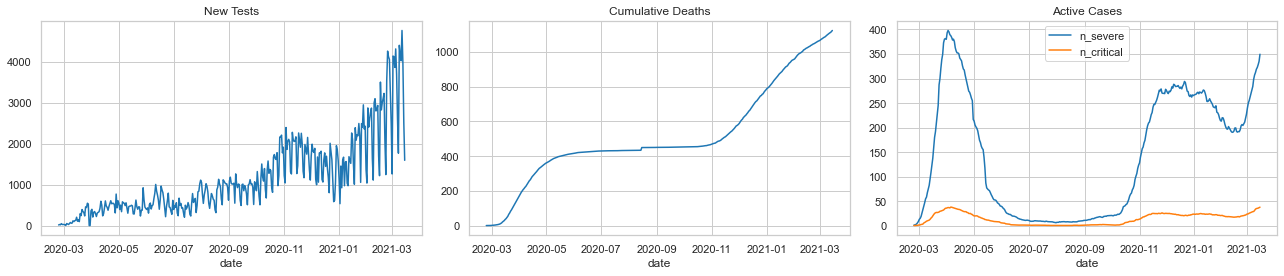

In [9]:
_, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=False)

sns.lineplot(data=df, x='date', y='new_tests', ax=axes[0]).set(title='New Tests', ylabel='')
sns.lineplot(data=df, x='date', y='cum_deaths', ax=axes[1]).set(title='Cumulative Deaths', ylabel='')
sns.lineplot(data=df, x='date', y='n_severe', label='n_severe', ax=axes[2]).set(title='Active Cases')
sns.lineplot(data=df, x='date', y='n_critical', label='n_critical', ax=axes[2]).set(ylabel='')

plt.tight_layout()

In [10]:
default_params = dict(
    start_day=df['date'].iloc[0],
    end_day=df['date'].iloc[-1],
    pop_size=pop_size / pop_scale,
    pop_scale=pop_scale,
    rescale=True,
    n_beds_hosp=pop_size * 370.4 / 100e3,
    n_beds_icu=pop_size * 14.46 / 100e3,
    quar_period=14,
    verbose=0
)

In [11]:
interv_days = pd.Series({
    pd.to_datetime('2020-03-08'): 'red',
    pd.to_datetime('2020-05-18'): 'summer',
    pd.to_datetime('2020-09-15'): 'fall',
    pd.to_datetime('2020-11-08'): 'yellow',
    pd.to_datetime('2020-11-15'): 'orange',
    pd.to_datetime('2020-12-10'): 'yellow',
    pd.to_datetime('2020-12-21'): 'orange',
    pd.to_datetime('2021-02-01'): 'yellow',
    pd.to_datetime('2021-02-21'): 'orange',
    pd.to_datetime('2021-03-01'): 'red'
})
interv_days.index = [(date.date() - df['date'].iloc[0]).days for date in interv_days.index]

def get_interventions(pars):
    return [
        cv.test_num('new_tests', quar_policy='both', sensitivity=0.8, do_plot=False),
        cv.contact_tracing(trace_probs=pars['trace_probs'], trace_time=pars['trace_time'], do_plot=False),
        cv.dynamic_pars(
            beta=dict(days=interv_days.index, vals=[pars[f'{p}_beta'] for p in interv_days]),
            n_imports=dict(days=interv_days.index, vals=[pars[f'{p}_imports'] for p in interv_days])
        )
    ]

In [12]:
import optuna as op

def objective(trial):
    # define learnable parameters
    initial_params = dict(
        pop_infected=trial.suggest_int('init_pop_infected', 10, int(pop_size / 100), step=10),
        n_imports=trial.suggest_float('init_n_imports', 0.0, 20.0, step=1e-1),
        beta=trial.suggest_float('init_beta', 0.0, 0.1, step=1e-3),
        **default_params
    )
    intervention_params = dict(
        trace_probs=trial.suggest_float('interv_trace_probs', 0.0, 1.0, step=1e-2),
        trace_time=trial.suggest_float('interv_trace_time', 0.0, 10.0, step=1e-1),
        **{f'{p}_beta': trial.suggest_float(f'interv_{p}_beta', 0.0, 0.2, step=1e-3) for p in interv_days},
        **{f'{p}_imports': trial.suggest_float(f'interv_{p}_imports', 0.0, 20.0, step=1e-1) for p in interv_days}
    )
    # define and run simulations
    sim = cv.Sim(pars=initial_params, interventions=get_interventions(intervention_params), datafile=df)
    msim = cv.MultiSim(sim)
    msim.run(n_runs=n_runs)
    # compute loss
    weights = {c: 1 for c in cols}
    mismatches = [s.compute_fit(keys=cols, weights=weights, estimator=custom_estimator).mismatch for s in msim.sims]
    return sum(mismatches) / n_runs

study = op.create_study()
study.optimize(func=objective, n_trials=n_trials)

[I 2021-03-16 15:45:58,133] A new study created in memory with name: no-name-b1dd55b4-d03f-4cb7-ba83-a916614a05fd
[I 2021-03-16 15:46:15,154] Trial 0 finished with value: 918.887555622256 and parameters: {'init_pop_infected': 2170, 'init_n_imports': 4.4, 'init_beta': 0.063, 'interv_trace_probs': 0.29, 'interv_trace_time': 8.6, 'interv_red_beta': 0.109, 'interv_summer_beta': 0.029, 'interv_fall_beta': 0.123, 'interv_yellow_beta': 0.14200000000000002, 'interv_orange_beta': 0.062, 'interv_red_imports': 12.100000000000001, 'interv_summer_imports': 19.700000000000003, 'interv_fall_imports': 7.1000000000000005, 'interv_yellow_imports': 11.4, 'interv_orange_imports': 8.0}. Best is trial 0 with value: 918.887555622256.


In [13]:
best_params = study.best_params
best_params

{'init_pop_infected': 2170,
 'init_n_imports': 4.4,
 'init_beta': 0.063,
 'interv_trace_probs': 0.29,
 'interv_trace_time': 8.6,
 'interv_red_beta': 0.109,
 'interv_summer_beta': 0.029,
 'interv_fall_beta': 0.123,
 'interv_yellow_beta': 0.14200000000000002,
 'interv_orange_beta': 0.062,
 'interv_red_imports': 12.100000000000001,
 'interv_summer_imports': 19.700000000000003,
 'interv_fall_imports': 7.1000000000000005,
 'interv_yellow_imports': 11.4,
 'interv_orange_imports': 8.0}

In [ ]:
results = pd.DataFrame([dict(objective=t.value, **t.params) for t in study.trials])
results = results[results['objective'] <= results['objective'].quantile(.05)]
results = results.describe().loc[['count', 'min', 'max']]
results = results.append(pd.Series({'objective': study.best_value, **best_params}, name='best'))
results = results.transpose().astype({'count': 'int'})
results

In [ ]:
initial_params = {k[5:]: v for k, v in best_params.items() if k.startswith('init_')}
initial_params.update(default_params)

intervention_params = {k[7:]: v for k, v in best_params.items() if k.startswith('interv_')}
interventions = get_interventions(intervention_params)

sim = cv.Sim(pars=initial_params, interventions=interventions, datafile=df)
msim = cv.MultiSim(sim)
msim.run(n_runs=30)

msim.mean()
msim.plot(cols);

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True, tight_layout=True)

for col in cols:
    sns.lineplot(data=df, x='date', y=col, label=col, ax=axes[0]).set(title='Real Data', ylabel='')
    sns.lineplot(data=msim.results, x='date', y=col, label=col, ax=axes[1]).set(title='Simulated Data', ylabel='')